In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline                                           
from sklearn.preprocessing import StandardScaler                                     
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
from sklearn import tree
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
from multiprocessing import Pool
from tqdm import tqdm
%run -i '../../../../../../utils.py'

# Get data

In [19]:
# read meta data
df_meta = pd.read_csv('../../../../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin'] # only for inulin group
df_meta = df_meta[df_meta.Day != 0] # remove day 0

# read SCFA data
df_scfa = pd.read_csv('../../../../../../our_data/SCFA.csv', index_col=0)

# read bacterial abundance
df_bac = pd.read_csv('../../../../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# find common samples
common_samples = list(set(df_meta.index).intersection(df_scfa.index).intersection(df_bac.index))
df_meta = df_meta.loc[common_samples]
df_scfa = df_scfa.loc[common_samples]
df_bac = df_bac.loc[common_samples]

# add day to df_bac
all_days = [1, 2, 3, 5, 8, 10, 13, 19, 25, 31]
lines = []
for sample in df_bac.index:
    curr_line = [0]*len(all_days)
    curr_line[all_days.index(df_meta.loc[sample,'Day'])] = 1
    lines.append(curr_line)
df_line = pd.DataFrame(lines, columns=['Day_'+str(day_) for day_ in all_days], index=df_bac.index)
df_bac = pd.concat([df_bac, df_line], axis=1)

# Scan parameters

In [21]:
def run_random_forest(params):
    # get data
    xdata_train = np.asarray(df_bac.values)
    ydata_train = np.asarray(df_scfa[params['scfa']])

    print(params)
    # make pipeline
    clf = RandomForestRegressor(n_estimators=params['n_trees'],
                                max_features=params['max_features'],
                                random_state=0, 
                                oob_score=True, 
                                max_depth=params['max_depth'],
                                min_samples_split=params['min_samples_split'],
                                min_samples_leaf=params['min_samples_leaf']
                               )
    pipe = make_pipeline(StandardScaler(), SelectFromModel(clf, max_features=params['n_features_to_select'], threshold=-np.inf), clone(clf))  
    pipe.fit(xdata_train, ydata_train)
    return list([params['scfa'],
                 params['n_features_to_select'],
                 params['n_trees'],
                 params['max_features'],
                 params['max_depth'],
                 params['min_samples_split'],
                 params['min_samples_leaf'],
                 pipe[2].oob_score_])
       
#     # convert to panda
#     df_tmp = pd.DataFrame.from_dict(params_exp, orient='index').T
#     if df_oob is None:
#         df_oob = deepcopy(df_tmp)
#     else:
#         df_oob = pd.concat([df_oob, df_tmp], ignore_index=True)


In [22]:
# parameters to test
param_grid = {'scfa':['Acetate','Butyrate','Propionate'],
              'n_features_to_select':[2,4,8,16,32],
              'n_trees':[1024,2048,4096,8192],
              'max_features':['auto','sqrt','log2',0.16,0.32,0.64],
              'max_depth':[2,4,8,16],
              'min_samples_split':[2,4,8,16],
              'min_samples_leaf':[1,2,4]
             }
param_scores = Parallel(n_jobs=36)(delayed(run_random_forest)(params) for params in tqdm(ParameterGrid(param_grid)))

100%|██████████| 17280/17280 [4:17:55<00:00,  1.12it/s]  


In [23]:
df_res = pd.DataFrame(param_scores, columns=['scfa','n_features_to_select','n_trees','max_features','max_depth','min_samples_split','min_samples_leaf','oob'])
df_res.to_csv('param_grid_search_rf_oob.csv')
df_res.head()

,scfa,n_features_to_select,n_trees,max_features,max_depth,min_samples_split,min_samples_leaf,oob
0,Acetate,2,1024,auto,2,2,1,0.160482
1,Butyrate,2,1024,auto,2,2,1,0.401287
2,Propionate,2,1024,auto,2,2,1,0.404815
3,Acetate,2,2048,auto,2,2,1,0.162819
4,Butyrate,2,2048,auto,2,2,1,0.401386


# Run RF using best parameters

## intrapolation

In [24]:
lines = []
for scfa in ['Acetate','Propionate','Butyrate']:
    params = df_res[df_res.scfa==scfa].sort_values('oob', ascending=False).iloc[0]
    for group_to_exclude in ['A','B','C','D']:
        
        # split train/test data
        mice_to_keep = list(set(df_meta[df_meta.RandomizedGroup!=group_to_exclude].MiceID))
        samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
        mice_to_exclude = list(set(df_meta[df_meta.RandomizedGroup==group_to_exclude].MiceID))
        samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))
        
        # get X and Y data
        xdata_train = np.asarray(df_bac.loc[samples_to_keep].values)
        xdata_test = np.asarray(df_bac.loc[samples_to_exclude].values)
        ydata_train = np.asarray(df_scfa.loc[samples_to_keep, scfa])
        ydata_test = np.asarray(df_scfa.loc[samples_to_exclude, scfa])

        # make pipeline
        clf = RandomForestRegressor(n_estimators=params['n_trees'],
                                    max_features=params['max_features'],
                                    random_state=0, 
                                    oob_score=True, 
                                    max_depth=params['max_depth'],
                                    min_samples_split=params['min_samples_split'],
                                    min_samples_leaf=params['min_samples_leaf']
                                   )
        pipe = make_pipeline(StandardScaler(), SelectFromModel(clf, max_features=params['n_features_to_select'], threshold=-np.inf), clone(clf))  
        pipe.fit(xdata_train, ydata_train)
        
        # predict training set
        ydata_train_predicted = pipe.predict(xdata_train)
        ydata_test_predicted = pipe.predict(xdata_test)

        for sample_, obs_, pred_ in zip(samples_to_keep, ydata_train, ydata_train_predicted):
            day_ = df_meta.loc[sample_,'Day']
            lines.append([scfa, group_to_exclude, 'train', sample_, day_, obs_, pred_])
        for sample_, obs_, pred_ in zip(samples_to_exclude, ydata_test, ydata_test_predicted):
            day_ = df_meta.loc[sample_,'Day']
            lines.append([scfa, group_to_exclude, 'test', sample_, day_, obs_, pred_])

df_pred_intra = pd.DataFrame(lines, columns=['SCFA','Permutation','PredictionType','SampleID','Day','ObservedValue','PredictedValue'])
df_pred_intra.head()

,SCFA,Permutation,PredictionType,SampleID,Day,ObservedValue,PredictedValue
0,Acetate,A,train,sample459,5,33.146426,29.815091
1,Acetate,A,train,sample291,1,19.085337,19.090340
2,Acetate,A,train,sample247,25,14.320813,15.043623
3,Acetate,A,train,sample366,19,10.192844,12.817790
4,Acetate,A,train,sample61,5,34.218158,30.148731


## extrapolation

In [25]:
lines = []
for scfa in ['Acetate','Propionate','Butyrate']:
    params = df_res[df_res.scfa==scfa].sort_values('oob', ascending=False).iloc[0]
    for vendor_to_exclude in ['Beijing','Guangdong','Hunan','Shanghai']:
        
        # split train/test data
        mice_to_keep = list(set(df_meta[df_meta.Vendor!=vendor_to_exclude].MiceID))
        samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
        mice_to_exclude = list(set(df_meta[df_meta.Vendor==vendor_to_exclude].MiceID))
        samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))
        
        # get X and Y data
        xdata_train = np.asarray(df_bac.loc[samples_to_keep].values)
        xdata_test = np.asarray(df_bac.loc[samples_to_exclude].values)
        ydata_train = np.asarray(df_scfa.loc[samples_to_keep, scfa])
        ydata_test = np.asarray(df_scfa.loc[samples_to_exclude, scfa])

        # make pipeline
        clf = RandomForestRegressor(n_estimators=params['n_trees'],
                                    max_features=params['max_features'],
                                    random_state=0, 
                                    oob_score=True, 
                                    max_depth=params['max_depth'],
                                    min_samples_split=params['min_samples_split'],
                                    min_samples_leaf=params['min_samples_leaf']
                                   )
        pipe = make_pipeline(StandardScaler(), SelectFromModel(clf, max_features=params['n_features_to_select'], threshold=-np.inf), clone(clf))  
        pipe.fit(xdata_train, ydata_train)
        
        # predict training set
        ydata_train_predicted = pipe.predict(xdata_train)
        ydata_test_predicted = pipe.predict(xdata_test)

        for sample_, obs_, pred_ in zip(samples_to_keep, ydata_train, ydata_train_predicted):
            day_ = df_meta.loc[sample_,'Day']
            lines.append([scfa, vendor_to_exclude, 'train', sample_, day_, obs_, pred_])
        for sample_, obs_, pred_ in zip(samples_to_exclude, ydata_test, ydata_test_predicted):
            day_ = df_meta.loc[sample_,'Day']
            lines.append([scfa, vendor_to_exclude, 'test', sample_, day_, obs_, pred_])

df_pred_extra = pd.DataFrame(lines, columns=['SCFA','Permutation','PredictionType','SampleID','Day','ObservedValue','PredictedValue'])
df_pred_extra.head()

,SCFA,Permutation,PredictionType,SampleID,Day,ObservedValue,PredictedValue
0,Acetate,Beijing,train,sample459,5,33.146426,30.369021
1,Acetate,Beijing,train,sample291,1,19.085337,19.142132
2,Acetate,Beijing,train,sample366,19,10.192844,12.688193
3,Acetate,Beijing,train,sample61,5,34.218158,29.407140
4,Acetate,Beijing,train,sample306,3,8.261241,10.977074


## calculate R2

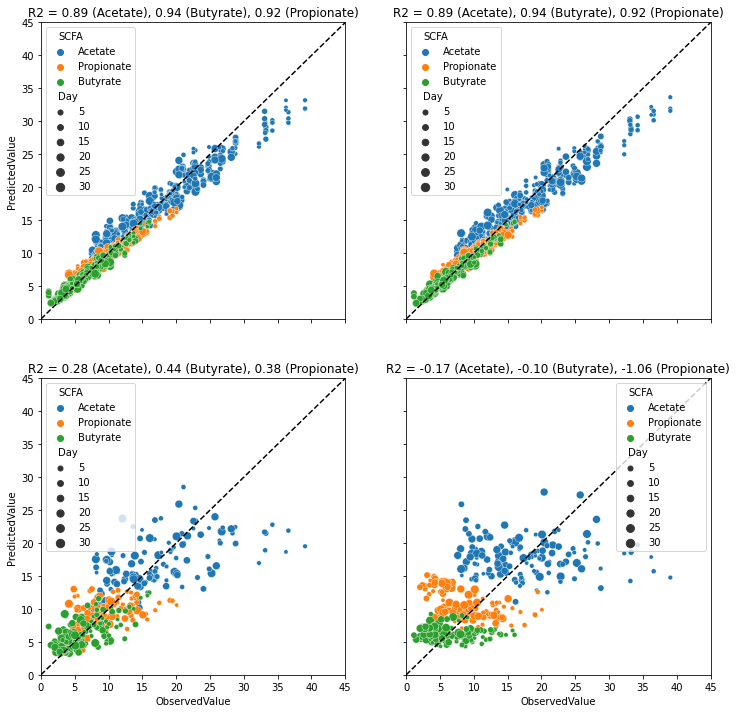

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)

for k,ptype in enumerate(['train','test']):
    # intrapolation
    df_intra_tmp = df_pred_intra[df_pred_intra['PredictionType']==ptype]
    _ = sns.scatterplot(x='ObservedValue', y='PredictedValue', hue='SCFA', size='Day', data=df_intra_tmp, ax=ax[k,0])
    # extrapolation
    df_extra_tmp = df_pred_extra[df_pred_extra['PredictionType']==ptype]
    _ = sns.scatterplot(x='ObservedValue', y='PredictedValue', hue='SCFA', size='Day', data=df_extra_tmp, ax=ax[k,1])
    
    # calculate R2
    r2_intra = []
    r2_extra = []
    for scfa in ['Acetate','Butyrate','Propionate']:
        # intrapolation
        df_intra_tmp2 = df_intra_tmp[df_intra_tmp.SCFA==scfa]
        r2_intra.append(r2_score(df_intra_tmp2.ObservedValue, df_intra_tmp2.PredictedValue))
        # extrapolation
        df_extra_tmp2 = df_extra_tmp[df_extra_tmp.SCFA==scfa]
        r2_extra.append(r2_score(df_extra_tmp2.ObservedValue, df_extra_tmp2.PredictedValue))
   
    # add title
    _ = ax[k,0].set_title('R2 = %2.2f (%s), %2.2f (%s), %2.2f (%s)'%(r2_intra[0], 'Acetate', r2_intra[1], 'Butyrate', r2_intra[2], 'Propionate'))
    _ = ax[k,1].set_title('R2 = %2.2f (%s), %2.2f (%s), %2.2f (%s)'%(r2_extra[0], 'Acetate', r2_extra[1], 'Butyrate', r2_extra[2], 'Propionate'))
    
    # set xlim and ylim
    _ = ax[0,k].set_xlim([0,45])
    _ = ax[1,k].set_xlim([0,45])
    _ = ax[0,k].set_ylim([0,45])
    _ = ax[1,k].set_ylim([0,45])
    _ = ax[0,k].plot([0,45],[0,45],'k--')
    _ = ax[1,k].plot([0,45],[0,45],'k--')